# Customers' age recognition

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Model-Analysis" data-toc-modified-id="Model-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Analysis</a></span></li></ul></div>

The supermarket chain "Good Seed" would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. 

Their shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
<br>Computer vision methods can be used to determine age of a person from a photo.
<br>The task then is **to build and evaluate a model for verifying approximate people's age by photo**. At the same time, the value of **MAE on the test sample should not exceed 8**.

## Exploratory data analysis

We have a set of photos of people with their age. Let's do an exploratory analysis of the dataset provided:
- Let's look at the dataset size.
- Let's plot the age distribution in the dataset.
- Let's print 10-15 photos on the screen and see how the dataset works.

We will also make conclusions about how the results of the analysis will affect the training of the model.

In [1]:
# import of libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print("The shape of the dataset:", labels.shape)

The shape of the dataset: (7591, 2)


In [4]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


The sample is relatively small - there are 7591 photos in the dataset.
<br>No missing values found in the dataset.

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


The average people's age in the photographs is greater than the median, which means that the age distribution is not symmetrical and skewed to the right.
<br>The people's age in the photographs in the dataset is between 1 and 100 years.

Let's plot the age distribution in the dataset:

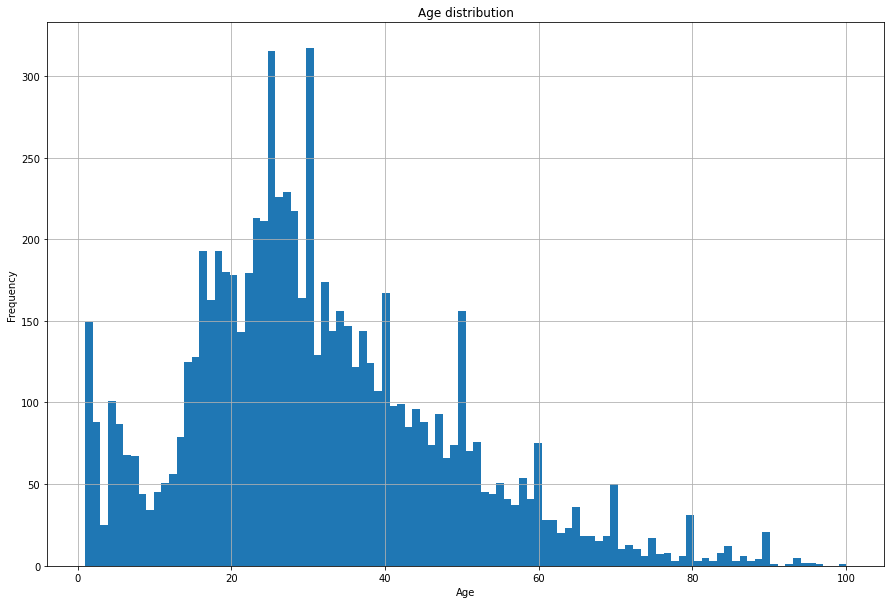

In [7]:
labels['real_age'].hist(bins=100, figsize=(15, 10))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution')
plt.show()

We paid attention to the peaks around "anniversary" years, which may be due to the fact that the real age was unknown to the person who marked the dataset, and they simply rounded it. Therefore, some "round" years in the dataset might be incorrect.
<br>We also noticed, that age distribution is asymmetrical and skewed to the right, taht can be explained by the demographic situation in the world.

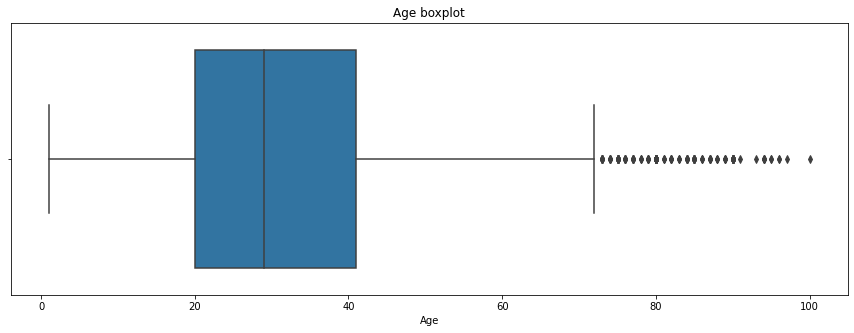

In [8]:
plt.figure(figsize=(15,5))
sns.boxplot(x=labels['real_age']).set(xlabel='Age')
plt.title('Age boxplot')
plt.show()

The boxplot above shows outliers at ages over 70. This is likely due to the fact that people over 70 are not as common as people in their 20s and 40s due to the demographic situation in the world.
<br>The presence of outliers can adversely affect the quality of training. It is likely that for ages where there are more photos, the model will train better and have a smaller prediction penalty, and vice versa.

Let's create an ImageDataGenerator generator:

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Let's print 12 photos on the screen and see how the dataset works:

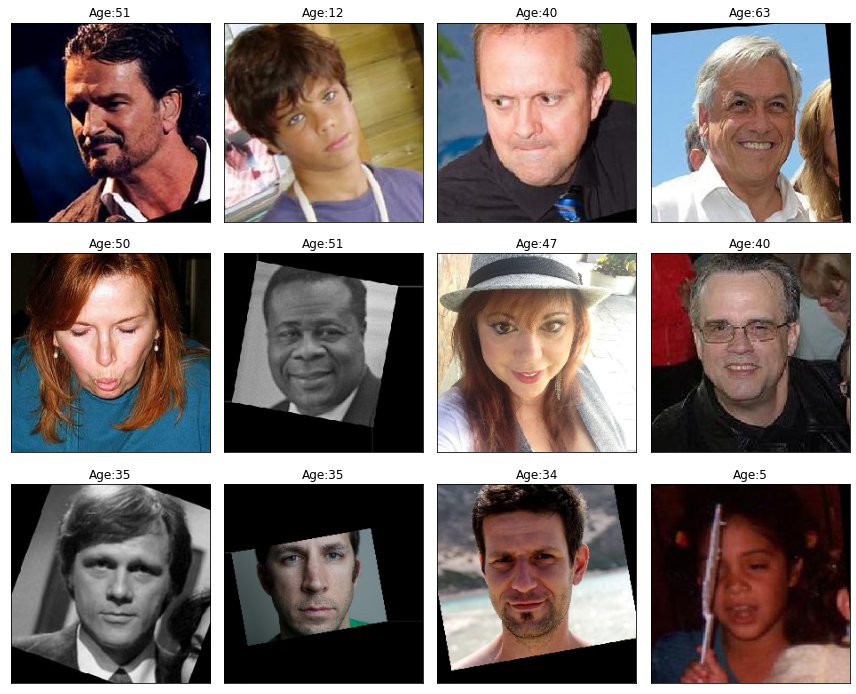

In [11]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age:' + str(target[i]))

From the printed photographs above we noticed the following:
- The general orientation of the photos is approximately the same - in some photos they have already been rotated for us to align the position of the face, which means we do not have to rotate them;
- The initial size of the images is different - it might be due to the visually noticeable difference in photo quality;
- There are black frames somewhere (they do not carry useful information);
- There are color and black and white photographs. 

As a result, we need to unify the size of the images before training the model.

### Conclusion

We downloaded and analyzed the data - a set of photos of people with their age.
- The sample is relatively small - there are 7591 photos in the dataset;
- No missing values found;
- The average people's age in the photographs is greater than the median, which means that the age distribution is not symmetrical and skewed to the right, which is also confirmed by the frequency histogram;
- The people's age in the photographs in the dataset is between 1 and 100 years;
- The boxplot shows outliers at ages over 70. This is likely due to the fact that people over 70 are not as common as people in their 20s and 40s. The presence of outliers can adversely affect the quality of training. It is likely that for ages where there are more photos, the model will train better and have a smaller prediction penalty;
- Photos are of different quality, size, color and black and white, people are from different angles, some photos look like they have already been augmented (for example, rotation), but the general orientation of the photos is approximately the same.

Thus, before training the model, we can perform unification of the image size. Beyond that, we can perform a slight augmentation in the form of a horizontal reflection, that allows us to increase the sample by 2 times. Moreover, the images obtained in this way are indistinguishable from the real ones. 

Since the age verification is a regression task, we will use MAE as a quality metric, and MSE as a loss function, since, as a rule, such neural networks train faster than with a MAE loss function. We will use the network architecture based on ResNet with the ReLU activation function so that there are no negative age values.

## Model Training

Let's prepare the data for training, train the neural network and calculate its quality:

*(The code in this section runs in a separate GPU platform, so it's formatted as a Markdown cell)*

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., vertical_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
                                                           x_col='file_name', y_col='real_age',
                                                           target_size=(224, 224), batch_size=32,
                                                           class_mode='raw', subset='training', seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
                                                         x_col='file_name', y_col='real_age',
                                                         target_size=(224, 224), batch_size=32,
                                                         class_mode='raw', subset='validation', seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = keras.models.Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    train_datagen_flow = train_data
    test_datagen_flow = test_data
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

The GPU platform output:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 65s - loss: 284.2118 - mae: 12.3884 - val_loss: 963.8891 - val_mae: 26.2869
Epoch 2/10
178/178 - 41s - loss: 97.3987 - mae: 7.4121 - val_loss: 694.6627 - val_mae: 20.8312
Epoch 3/10
178/178 - 46s - loss: 65.8102 - mae: 6.1061 - val_loss: 309.1280 - val_mae: 13.0540
Epoch 4/10
178/178 - 49s - loss: 48.3229 - mae: 5.3107 - val_loss: 130.9361 - val_mae: 8.7715
Epoch 5/10
178/178 - 40s - loss: 36.2856 - mae: 4.5931 - val_loss: 90.9072 - val_mae: 7.2291
Epoch 6/10
178/178 - 47s - loss: 28.1043 - mae: 4.0328 - val_loss: 82.0979 - val_mae: 6.8427
Epoch 7/10
178/178 - 49s - loss: 23.0298 - mae: 3.6093 - val_loss: 74.6470 - val_mae: 6.5019
Epoch 8/10
178/178 - 42s - loss: 18.4120 - mae: 3.2835 - val_loss: 75.7298 - val_mae: 6.5604
Epoch 9/10
178/178 - 40s - loss: 15.0404 - mae: 2.9827 - val_loss: 101.6255 - val_mae: 7.7451
Epoch 10/10
178/178 - 38s - loss: 13.4970 - mae: 2.7931 - val_loss: 73.2535 - val_mae: 6.4204

60/60 - 9s - loss: 73.2535 - mae: 6.4204
Test MAE: 6.4204
```

### Conclusion

We prepared the data for training, trained the neural network and calculated its quality.
<br>As a result, a trained neural network was obtained, which can determine the approximate age of a person by photo with mean average error of 6.4 years.

## Model Analysis

Thus, we built and trained a convolutional neural network on the dataset with photographs of people, and achieved the required MAE value on the test sample (according to the task, the MAE on the test sample should be no more than 8).
<br>Based on the goals of implementation of a computer vision system for processing customer photos and the resulting quality of the neural network, we can make the following conclusions:
- with the quality achieved, it can be difficult to control the conscientiousness of cashiers when selling alcohol; see [ideas of quality improvement](#ideas).
- it is quite possible to analyze purchases and offer products of interest to buyers of a specific age group, given the possible error of 6.4 years, this should not be critical.

**Ideas of quality improvement:**<a id='ideas'></a>
1. The quality of the input data: re-evaluate the age from the photo.
2. Error analysis: for example, the model makes a lot of mistakes in the segment of the elderly, but it works almost perfectly with young people. Then understand what ages it would be good to add to the sample of photos for additional training.
3. In addition, study the distribution of the target. It is possible that the sample was not randomly drawn (small bimodality is visible), see which age groups are underrepresented in order to add them to the sample later.